In [36]:
import pandas as pd
from pandas.tseries.offsets import BQuarterEnd,BMonthEnd
import datetime
from datetime import date
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt
#%matplotlib inline

#** GLOBALS
ASSETS = ['SPY','IEF','TLT','DBC','GLD']
WEIGHTS = [0.3,0.15,0.4,0.075,0.075]

data = yf.download("SPY DBC TLT IEF GLD",start="2008-01-01",end="2021-12-30")
df = pd.DataFrame(data['Adj Close'])

# Quartalsenden für Rebalancing hinzufügen
rebals = []
for idx in df[df.index.month == 5].index.date:
    rebals.append(BMonthEnd().rollforward(idx))

for idx in df[df.index.month == 11].index.date:
    rebals.append(BMonthEnd().rollforward(idx))

for i, rebal_date in enumerate(rebals):
    while rebal_date not in df.index:
        rebal_date += pd.offsets.BDay()
    rebals[i] = rebal_date

df['Rebalancing_Days'] = np.where(df.index.isin(np.unique(rebals)),1,0)

# Log-Renditen berechnen
for asset in ASSETS:
    df[asset+'_ret'] = df[asset].pct_change()# np.log(df[asset]) / np.log(df[asset].shift(1))

# Then calculate the contribution to the portfolio value of each asset.
# for the first day the contribution is obviously the dot product of the assets and the weights. On the next day the contribution is however different as the asset prices moved. That way we can better model the value of the portfolio later on

[*********************100%***********************]  5 of 5 completed


In [37]:
def calculate_nav_contribution(df, assets, weights):

    # Create empty columns to store NAV Contribution for each asset  
    for asset in assets:
        df[asset+'_NAV_CTR'] = np.nan

    # Create empty NAV column
    df["NAV"] = np.nan

    # Initialize CTR for each asset to their respective weight on first day
    df.loc[df.index[0], [col for col in df.columns if '_NAV_CTR' in col]] = weights

    # Set NAV in the first row to the sum of the asset weights
    df.at[df.index[0], "NAV"] = (df[[col for col in df.columns if '_NAV_CTR' in col]]).sum(axis=1)[0]


    for i in range(len(df))[1:]:

        # Rebalancing Logic here
        if df.loc[df.index[i-1],'Rebalancing_Days'] == 1:
            # print(f"Rebalancing on {df.index[i]}")
            for asset in assets:
                df.at[df.index[i], asset+"_NAV_CTR"] = df.loc[df.index[i-1], 'NAV'] * df.loc[df.index[0], asset+'_NAV_CTR'] * ( 1 + df.loc[df.index[i], asset+'_ret'] )

        # Portfolio Return Calculation if not on a rebalancing day
        else:
            # Calculate Returns
            for asset in assets:
                df.at[df.index[i], asset+"_NAV_CTR"] = df.loc[df.index[i-1], asset+'_NAV_CTR']* ( 1 + df.loc[df.index[i],asset+'_ret'])

        # Calculate the NAV with the returns in row i
        df.at[df.index[i], "NAV"] = (df[[col for col in df.columns if '_NAV_CTR' in col]]).sum(axis=1)[i]

    return df

In [38]:
df = calculate_nav_contribution(df, ASSETS, WEIGHTS)

<AxesSubplot:xlabel='Date'>

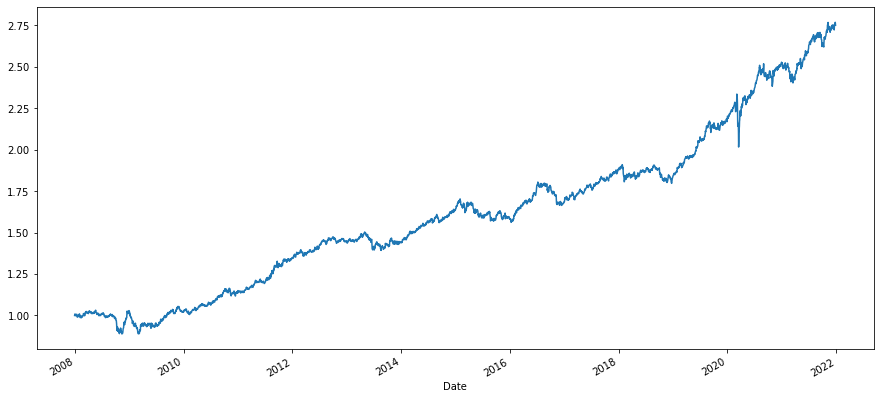

In [39]:
df["NAV"].plot(kind='line',figsize=(15,7))

In [42]:
# Calculate cumulative returns
cumulative_returns = (df["NAV"][-1] / df["NAV"][0]) - 1

# Calculate annual return
num_days = (df.index[-1] - df.index[0]).days
annual_return = (1 + cumulative_returns) ** (252 / num_days) - 1

# Calculate daily standard deviation
daily_std = np.std(df["NAV"].pct_change())

# Calculate annual standard deviation
annual_std = daily_std * np.sqrt(252)

# Calculate drawdowns
cumulative_returns = df["NAV"] / df["NAV"].iloc[0]
peaks = cumulative_returns.cummax()
drawdowns = (cumulative_returns - peaks) / peaks

# Calculate maximum drawdown
max_drawdown = drawdowns.min()

print("Annual return: {:.2%}".format(annual_return))
print("Annual standard deviation: {:.2%}".format(annual_std))
print("Sharpe Ratio: {:.2}".format(annual_return/annual_std))
print("Max drawdown: {:.2%}".format(max_drawdown))


Annual return: 5.11%
Annual standard deviation: 7.56%
Sharpe Ratio: 0.68
Max drawdown: -13.82%


In [33]:
np.std(df['NAV'].pct_change())*np.sqrt(252)

0.08119940565464759

In [24]:
4.42/7.68

0.5755208333333334

In [ ]:
np.std(df['NAV'].pct_change())*np.sqrt(252)
# df['NAV'].pct_change()
np.std(np.exp(df['SPY_ret']).pct_change())*np.sqrt(252)

In [ ]:
df[['portfolio_val'] + [col for col in df.columns if '_ret' in col]].plot(figsize=(10,6))
plt.ylabel('Value')
plt.show()

In [ ]:
# df['portfolio'] = df[ASSETS].dot(WEIGHTS)
# df['portfolio_ret'] = np.log(df['portfolio']) / np.log(df['portfolio'].shift(1))

In [ ]:
df_ohne_rebal = df.copy()

In [ ]:
# for rebal_date in rebals:
#     rebal_date = pd.to_datetime(rebal_date)
#     if df.loc[rebal_date, 'Rebalancing_Days'] == 1:
#         df.loc[rebal_date,'portfolio'] = df.loc[rebal_date,ASSETS].dot(WEIGHTS)

# update portfolio value on rebalancing days
for rebal_date in rebals:
    rebal_date = pd.to_datetime(rebal_date)
    df.loc[rebal_date, "portfolio"] = df.loc[rebal_date, "portfolio_ret"].cumprod() * df.loc[rebal_date, "portfolio"]

In [ ]:

for rebal_date in rebals:
    if df.loc[rebal_date, 'Rebalancing_Days'] == 1:
        # Calculate current asset prices at rebalancing date
        asset_prices = df.loc[rebal_date, ASSETS]
        # Update weights based on current asset prices
        WEIGHTS = WEIGHTS * asset_prices / df.loc[rebal_date, 'portfolio']
        # Calculate new portfolio value using updated weights
        df.loc[rebal_date:, 'portfolio'] = df.loc[rebal_date:, ASSETS].dot(WEIGHTS)


In [ ]:
df[df["Rebalancing_Days"]==1].head(5)

In [ ]:
df_ohne_rebal[df_ohne_rebal["Rebalancing_Days"]==1].head(5)

In [ ]:
df[99:105]

In [ ]:
df_ohne_rebal[99:105]